# Toronto Neighborhoods clustering

Firstly we generate the the dataframe as shown in the previous sections.

## section 1

In [1]:
#importing necessary libraries
from bs4 import BeautifulSoup
import lxml
import requests
import pandas as pd
import numpy as np

In [2]:
#webscapping the link
source=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(source,'lxml')
table=soup.find('table')

In [3]:
#getting column headers
columns=[]
for column_name in table.find_all('th'):
    columns.append(column_name.text.split('\n')[0])
df=pd.DataFrame(columns=columns)

In [4]:
#getting the data from the rows of table
column1=[]
column2=[]
column3=[]

for data in table.tbody.find_all('tr'):
    try:
        column1.append(data.find_all('td')[0].text.split('\n')[0])
        column2.append(data.find_all('td')[1].text.split('\n')[0])
        column3.append(data.find_all('td')[2].text.split('\n')[0])
    except:
        pass
df['Postal code']=column1
df['Borough']=column2
df['Neighborhood']=column3

In [5]:
#cleaning table by removing empty data
df=df[df['Borough']!='Not assigned'].reset_index().drop('index',axis=1)

In [6]:
#replacing '/' with ',' in neighborhood
column3=[]
for data in df['Neighborhood']:
    column3.append(','.join(map(str,data.split('/'))))
df['Neighborhood']=column3   

In [7]:
df.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [8]:
df.shape

(103, 3)

## section 2

In [9]:
# reading the csv for postal code information
postal=pd.read_csv('http://cocl.us/Geospatial_data')
postal.rename(columns={'Postal Code':'Postal code'},inplace=True)

In [10]:
#Adding latitude and longitude in df
df=df.sort_values('Postal code').reset_index().drop('index',1)
df=df.merge(postal)

In [11]:
df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## section 3

Now we have our dataframe , lets visualize the city with the help of folium.

In [12]:
#importing libraries
from geopy.geocoders import Nominatim
from pandas import json_normalize
import folium

In [13]:
#Getting the coordinates of Toronto
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [14]:
#Plotting the map
toronto_map=folium.Map(location=[latitude,longitude],zoom_start=11)
for lat,long,label in zip(df.Latitude,df.Longitude,df['Postal code']):
    label=folium.Popup(label,parse_html=True)
    folium.features.CircleMarker(
    [lat,long],popup=label,color='green',radius=5,fill_opacity=0.3,fill=True,fill_color='green'
    ).add_to(toronto_map)
toronto_map

Now , we are only going to consider the boroughs with the word Toronto in their names. 

In [15]:
df_slice=df[df['Borough'].str.contains('Toronto')].reset_index(drop=True)
df_slice.shape

(39, 5)

Lets check the sliced dataframe.

In [16]:
df_slice.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West , Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar , The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Let us plot the map of the sliced boroughs now.

In [17]:
toronto_map=folium.Map(location=[latitude,longitude],zoom_start=12)
for lat,long,label in zip(df_slice.Latitude,df_slice.Longitude,df_slice['Postal code']):
    label=folium.Popup(label,parse_html=True)
    folium.features.CircleMarker(
    [lat,long],popup=label,color='green',radius=5,fill_opacity=0.3,fill=True,fill_color='green'
    ).add_to(toronto_map)
toronto_map

#### Using foursquare api to explore the different postal code areas

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal code', 
                  'Postal code Latitude', 
                  'Postal code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
toronto_venues=getNearbyVenues(df_slice['Postal code'],df_slice.Latitude,df_slice.Longitude)

In [21]:
toronto_venues.head()

,Postal code,Postal code Latitude,Postal code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4E,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop


Now we have a dataframe that contains the venues in all postal codes

#### One hot encoding
Generating numerical variables out of venue variable.

In [22]:
toronto_postal=pd.get_dummies(toronto_venues['Venue Category'])
toronto_postal['Postalcode']=toronto_venues['Postal code']
toronto_postal=toronto_postal.groupby('Postalcode').mean().reset_index()
toronto_postal.head()

,Postalcode,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,M4E,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.20000,0.0,0.0,0.0,0.0,0.000,0.0,0.00000
1,M4K,0.0,0.0,0.0,0.0,0.0,0.0,0.02381,0.0,0.0,...,0.0,0.0,0.02381,0.0,0.0,0.0,0.0,0.000,0.0,0.02381
2,M4L,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000,0.0,0.00000
3,M4M,0.0,0.0,0.0,0.0,0.0,0.0,0.05000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.025,0.0,0.02500
4,M4N,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000,0.0,0.00000


### clustering

In [23]:
from sklearn.cluster import KMeans

Calculating the squared sum of errors for a range of values of k. We can find the optimum value of k by elbow method, that is choosing k for which there is a change in slope in graph of k vs sse.

In [24]:
sse=[]
for k in range(1,10):
    kmeans=KMeans(init='k-means++',n_clusters=k)
    kmeans.fit(toronto_postal.drop('Postalcode',1))
    sse.append(kmeans.inertia_)

In [25]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'SSE')

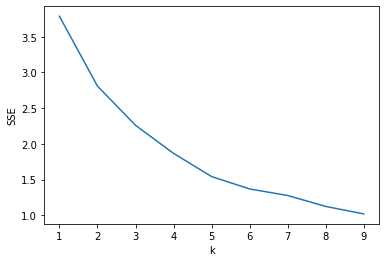

In [26]:
plt.plot(range(1,10),sse)
plt.xlabel('k')
plt.ylabel('SSE')

We can notice an elbow point at k=4.

In [27]:
kmeans=KMeans(init='k-means++',n_clusters=4,random_state=5)
kmeans.fit(toronto_postal.drop('Postalcode',1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=5, tol=0.0001, verbose=0)

In [28]:
klabels=kmeans.labels_
klabels

array([3, 3, 3, 3, 0, 3, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

Now that we have got the cluster labels ,let's add it the sliced dataframe.

In [29]:
df_slice['kcluster']=klabels
df_slice.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude,kcluster
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,3
1,M4K,East Toronto,"The Danforth West , Riverdale",43.679557,-79.352188,3
2,M4L,East Toronto,"India Bazaar , The Beaches West",43.668999,-79.315572,3
3,M4M,East Toronto,Studio District,43.659526,-79.340923,3
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0


Finally, plotting the map of the postal codes along with their cluster labels as found by kmeans clustering. We are using different colours to differentiate between clusters.

In [30]:
toronto_map=folium.Map(location=[latitude,longitude],zoom_start=12)
color=['red','orange','yellow','green','blue','purple','black']
for lat,long,label,cluster in zip(df_slice.Latitude,df_slice.Longitude,df_slice['Postal code'],df_slice.kcluster):
    label=folium.Popup(label,parse_html=True)
    folium.features.CircleMarker(
    [lat,long],popup=label,color=color[cluster],radius=5,fill_opacity=0.3,fill=True,fill_color=color[cluster]
    ).add_to(toronto_map)
toronto_map

We have found that most of the postal code areas fall under one cluster label. That might be due to the similarities in the venues present in them. This is a problem as our task of segmentation has only been able to segment out very few areas based on postal code